# Pretraining a Born Classifier

We'd like to extract as much performance form Born as possible, without complicating the model (we've seen that ensembling is not particularly effective anyhow, see the `born_ensemble.ipynb` notebook).

Pretraining seems like a natural way to go about it!

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt 
import seaborn as sns

import joblib

from bornrule import BornClassifier

from utils import prepare_data

## Data preparation

In [2]:
datadir = "data"
df_in = pd.read_parquet(os.path.join(datadir, "pretrain.parquet"))

df_out = prepare_data(df_in, num_processes=5)

[+] Loading data from prepared.parquet.


In [3]:
df_out.sample(15)

,sentence_id,token,pos,dep,ner_tag
1532470,9,Berlin,PROPN,compound,FAC
5473756,0,),PUNCT,punct,NONE
24264738,6,victory,NOUN,dobj,NONE
6300171,1,to,ADP,prep,NONE
13521186,5,film,NOUN,nsubjpass,NONE
8636967,1,2010,NUM,pobj,DATE
34954115,0,river,NOUN,attr,NONE
2254232,1,.,PUNCT,punct,NONE
11327988,0,post,ADJ,amod,NONE
13445257,3,period,NOUN,dobj,NONE


In [4]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35824413 entries, 0 to 35824412
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   sentence_id  int64 
 1   token        object
 2   pos          object
 3   dep          object
 4   ner_tag      object
dtypes: int64(1), object(4)
memory usage: 1.3+ GB


In [5]:
df_out['ner_tag'].value_counts()

ner_tag
NONE           26635602
ORG             2460284
PERSON          1723805
DATE            1662194
GPE             1188244
CARDINAL         425493
NORP             370960
LOC              271220
WORK_OF_ART      215003
FAC              195547
QUANTITY         193367
EVENT            176207
ORDINAL          122088
PRODUCT           51924
TIME              30588
LAW               29359
MONEY             27780
PERCENT           23396
LANGUAGE          21352
Name: count, dtype: int64

## Data processing

We'll encode the categorical values more or less as in the CoNLL case, i.e., to ordinal ones instead of one-hot encoded ones.

In [6]:
cols_to_encode = set(df_out.columns) - {'sentence_id', 'token'}

In [7]:
encoded_cols = []
ordinal_mappings = {}
for col in cols_to_encode:
    ordinal_encoder = OrdinalEncoder(dtype=np.int8)
    encoded_col_and_name = (ordinal_encoder.fit_transform(df_out[[col]]), ordinal_encoder.get_feature_names_out()[0])
    encoded_cols.append(encoded_col_and_name)

    # keep track of the mappigs for later (note that the encoding proceeds in the order in which the features appear in the list => the first element is encoded as 0, the second as 1, etc.)
    ordinal_mappings[ordinal_encoder.get_feature_names_out()[0]] = ordinal_encoder.categories_[0]

In [8]:
columns_to_keep = ['sentence_id', 'token']

encoded_df = pd.DataFrame()
for encoded_col, column in encoded_cols:
    encoded_df[column] = encoded_col.flatten()

encoded_df = pd.concat([df_out[columns_to_keep], encoded_df], axis=1)

In [9]:
encoded_df.sample(15)

,sentence_id,token,dep,pos,ner_tag
14856637,0,:,41,12,9
20183894,7,",",41,12,9
5580800,4,and,12,4,9
14879600,0,–,41,12,9
35425730,1,Swail,35,11,14
31175766,5,grew,43,16,9
3291867,12,like,39,1,9
17926427,7,3,31,8,0
1210772,7,critically,4,2,9
14428970,0,(,41,12,12


Now we proceed as we did in the CoNLL notebook.

In [10]:
X_train_valid, X_test = train_test_split(encoded_df, test_size=0.15)
X_train, X_valid = train_test_split(X_train_valid, test_size=0.3)

In [11]:
y_train = X_train.ner_tag.to_list()
X_train = X_train.drop('ner_tag', axis=1)

y_valid = X_valid.ner_tag.to_list()
X_valid = X_valid.drop('ner_tag', axis=1)

y_test = X_test.ner_tag.to_list()
X_test = X_test.drop('ner_tag', axis=1)

In [12]:
dict_vec = DictVectorizer()

X_train = dict_vec.fit_transform(X_train.to_dict('records'))
X_val = dict_vec.transform(X_valid.to_dict('records'))
X_test = dict_vec.transform(X_test.to_dict('records'))

## Training

In [13]:
born = BornClassifier()
# ~8s to train on ~36M tokens is quite impressive!
born.fit(X_train, y_train)

BornClassifier()

This model, unlike the CoNLL one, we do need to save!

In [14]:
timestamp = datetime.now().strftime("%d%m%Y-%H%M%S")
log_path = os.path.join("models", f"pretrained_bornclf_{timestamp}")
print(f"[+] Saved to {joblib.dump(born, log_path)}.")

[+] Saved to ['models/pretrained_bornclf_20082024-120438'].


In [15]:
# born = joblib.load(log_path)

In [16]:
y_pred = born.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred, labels=np.unique(y_train)))

              precision    recall  f1-score   support

           0       0.45      0.30      0.36     64563
           1       0.92      0.40      0.56    250530
           2       0.37      0.53      0.44     26192
           3       0.30      0.20      0.24     29265
           4       0.75      0.49      0.60    178102
           5       0.52      0.90      0.66      3226
           6       0.01      0.27      0.01      4542
           7       0.14      0.47      0.21     41691
           8       0.03      0.60      0.07      4065
           9       0.98      0.46      0.63   3988733
          10       0.77      0.70      0.73     55752
          11       0.07      0.97      0.14     18228
          12       0.87      0.15      0.26    370535
          13       0.03      0.57      0.05      3578
          14       0.13      0.93      0.22    260947
          15       0.10      0.28      0.15      8172
          16       0.60      0.48      0.54     29172
          17       0.08    

A curious result.

Perhaps visualising the confusion matrix will tell us more!

In [17]:
labels = ordinal_mappings['ner_tag']
cm = confusion_matrix(y_test, y_pred, labels=range(len(labels)), normalize='true')

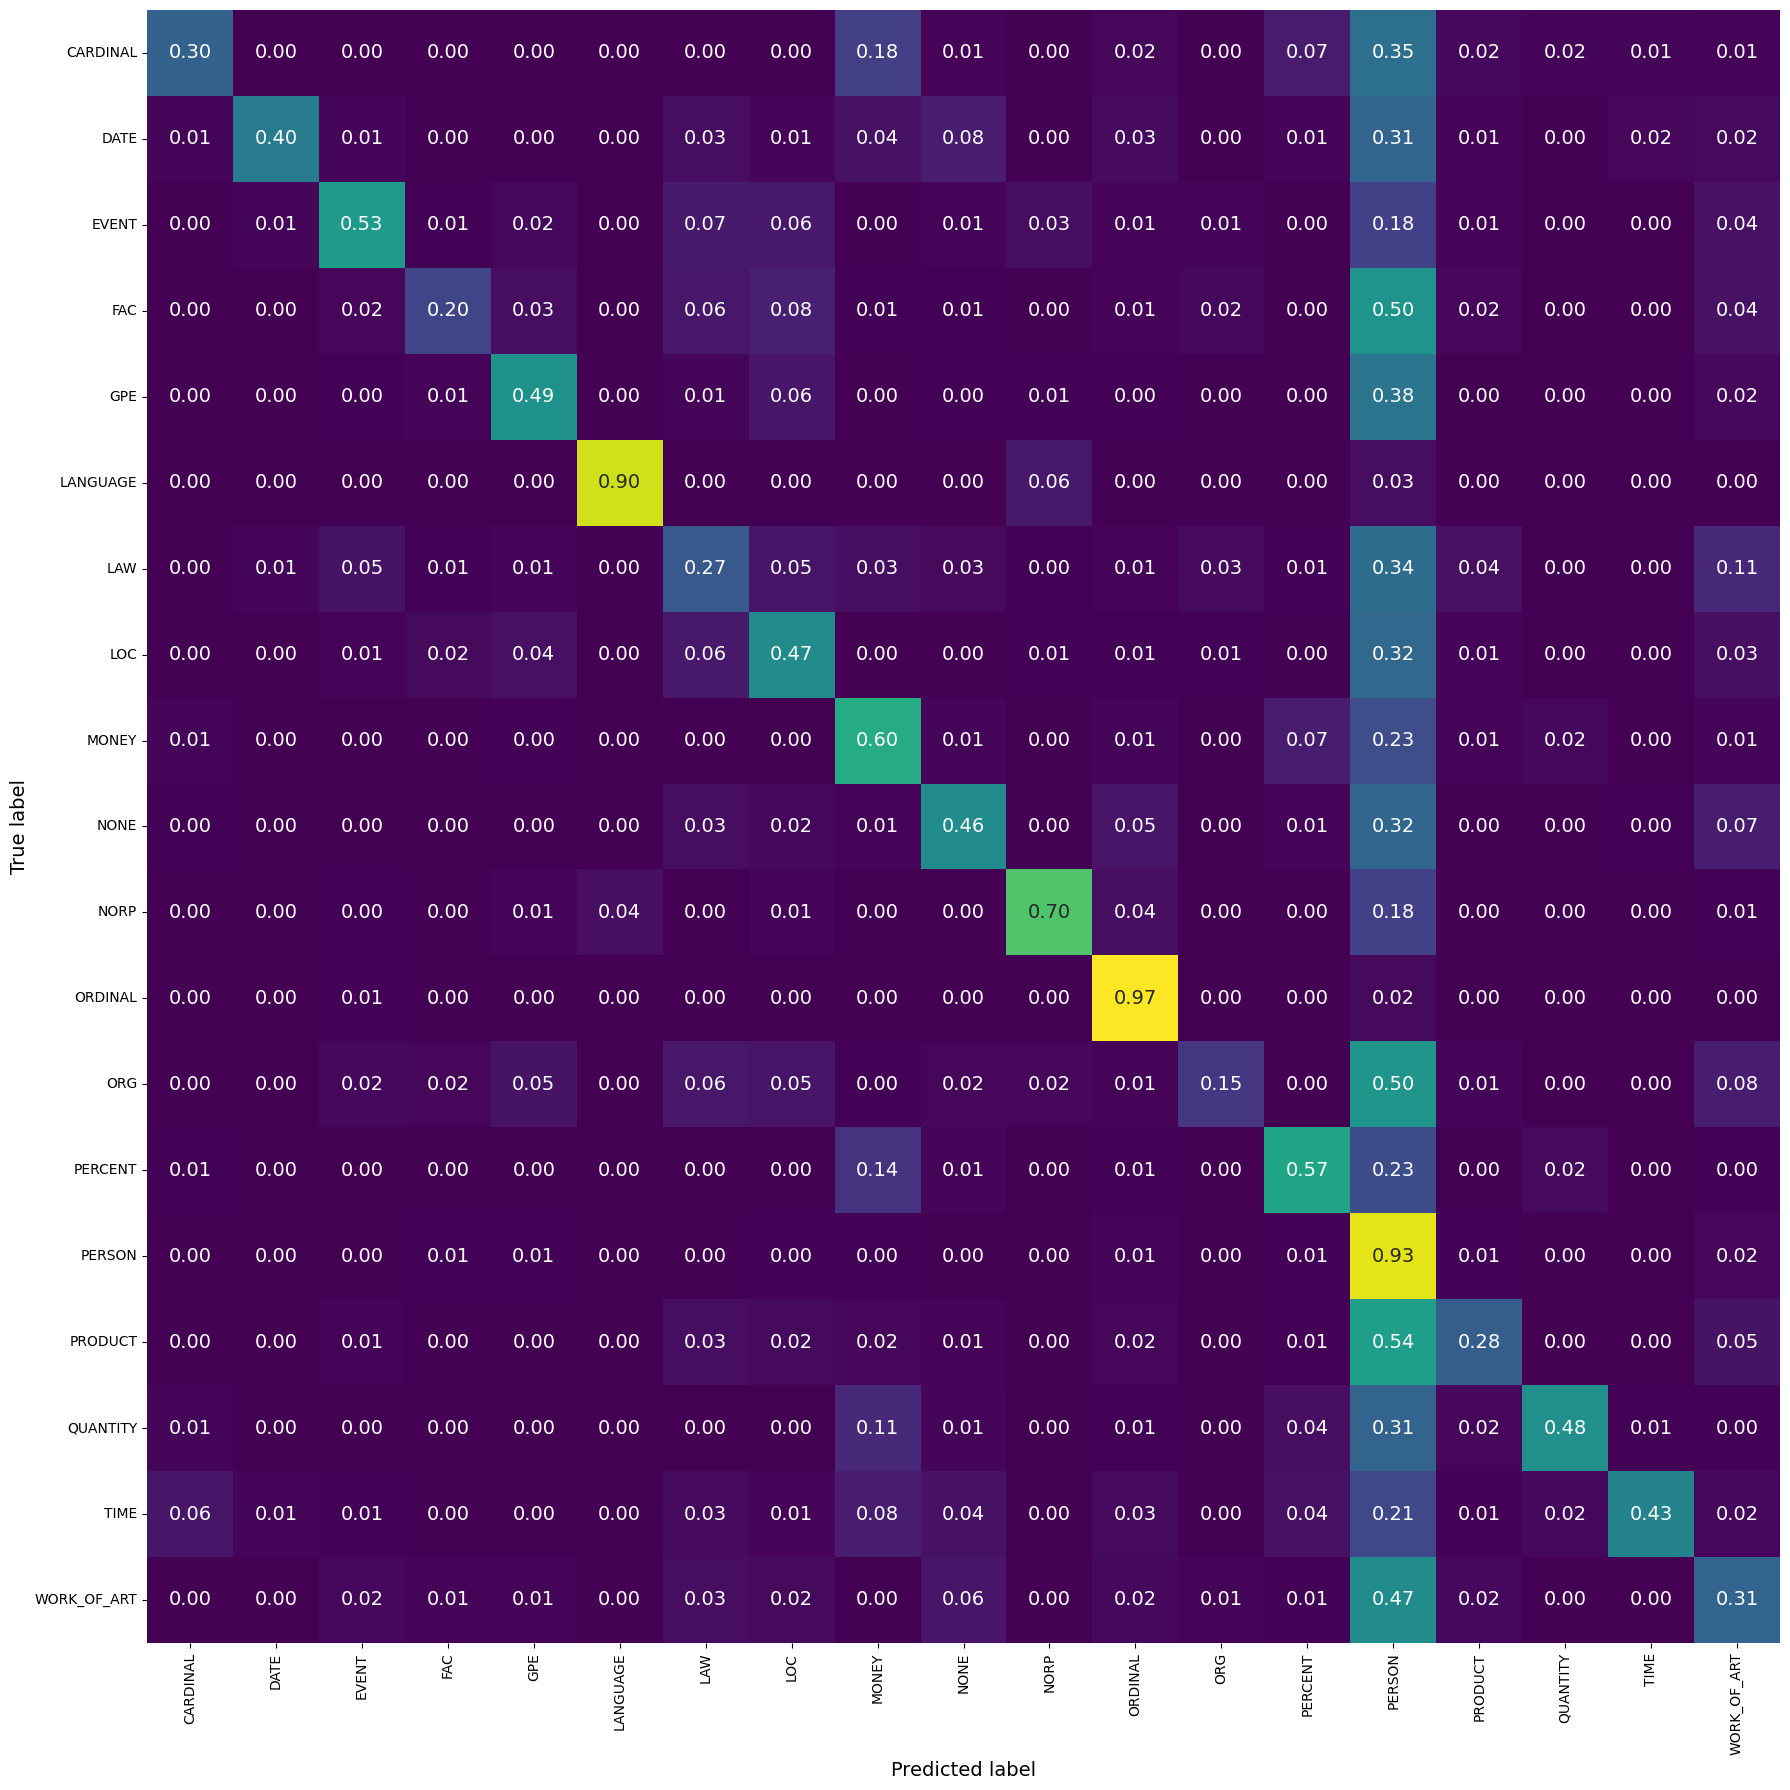

In [18]:
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(18, 18))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap='viridis', 
            xticklabels=labels, yticklabels=labels, 
            annot_kws={'size': 14}, cbar=False)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

plt.tight_layout()
plt.show()

This confusion matrix is actually quite a bit more heartening than the classification report: it's quite clear that the classifier has, in fact, learned something!

It's interesting to note that it seems to be the most confused about the `PERSON` tag.
Intuitively, this is not exceedingly surprising, especially when one looks at what person entities are most often confused with:
- `ORG`s (unsurprisingly, seeing as many organisations are named after people),
- `PRODUCT`s (for more or less the same reason as with organisations),
- `FAC`s (unsurprisingly, seeing as infrastructure is often named after people, e.g., the JFK Airport).

## Explanation 

In [19]:
features = dict_vec.get_feature_names_out()
columns = ordinal_mappings['ner_tag']
explain_df = pd.DataFrame(born.explain().toarray(), index=features, columns=columns)

In [20]:
features

array(['dep', 'pos', 'sentence_id', ..., 'token=𝛿', 'token=📖', 'token=𡨸南'],
      dtype=object)

In [21]:
ordinal_mappings['ner_tag']

array(['CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW',
       'LOC', 'MONEY', 'NONE', 'NORP', 'ORDINAL', 'ORG', 'PERCENT',
       'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART'],
      dtype=object)

In [22]:
explain_df.loc['pos']

CARDINAL       0.008269
DATE           0.008228
EVENT          0.009974
FAC            0.009911
GPE            0.010321
LANGUAGE       0.007889
LAW            0.009241
LOC            0.009926
MONEY          0.008540
NONE           0.008653
NORP           0.006532
ORDINAL        0.003751
ORG            0.009855
PERCENT        0.007961
PERSON         0.010622
PRODUCT        0.009910
QUANTITY       0.008787
TIME           0.007890
WORK_OF_ART    0.009356
Name: pos, dtype: float64

Let's use the same example as in the `born_on_conll.ipynb` notebook.

In [23]:
explain_df.loc['token=EU'].sort_values(ascending=False)

ORG            0.001351
EVENT          0.000812
GPE            0.000480
FAC            0.000465
WORK_OF_ART    0.000382
PERSON         0.000263
NONE           0.000056
LOC            0.000000
MONEY          0.000000
DATE           0.000000
NORP           0.000000
ORDINAL        0.000000
LAW            0.000000
PERCENT        0.000000
LANGUAGE       0.000000
PRODUCT        0.000000
QUANTITY       0.000000
TIME           0.000000
CARDINAL       0.000000
Name: token=EU, dtype: float64

In [24]:
explain_df['LANGUAGE'].sort_values(ascending=False).head(15)

token=English       0.229458
token=Arabic        0.053889
token=Hebrew        0.052983
token=Spanish       0.033854
token=French        0.033355
token=Filipino      0.032976
token=Latin         0.023144
token=Russian       0.015736
token=Chinese       0.013673
token=Mandarin      0.013355
token=German        0.013017
token=Cantonese     0.012118
token=Portuguese    0.011950
token=Japanese      0.010217
token=Polish        0.008550
Name: LANGUAGE, dtype: float64